In [53]:
from fastai.tabular.all import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_csv('../credit_risk_dataset.csv')
display(df)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [55]:
categorical_cols = ['person_home_ownership', 'loan_intent']
continuous_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
binary_col  = 'cb_person_default_on_file'

ordinal_col = 'loan_grade'
custom_order = ['A', 'B', 'C', 'D', 'E']

target = 'loan_status'


In [56]:
class EncodeBinary(Transform):
    def encodes(self, df: pd.DataFrame):
        df[binary_col] = df[binary_col].map({'Y': 1, 'N': 0})

class EncodeOrdinal(Transform):
    def encodes(self, df: pd.DataFrame):
        df[ordinal_col] = df[ordinal_col].map({val: i for i, val in enumerate(custom_order)})

In [57]:
procs = [Categorify, FillMissing, EncodeBinary(), EncodeOrdinal()] # Normalize


splits = RandomSplitter(valid_pct=0.2)(range_of(df))

to = TabularPandas(df, procs=procs, cat_names=categorical_cols, cont_names=continuous_cols, y_names=target, splits=splits)
dataloader = to.dataloaders(bs=64)
dataloader.show_batch()

,person_home_ownership,loan_intent,person_emp_length_na,loan_int_rate_na,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,OWN,EDUCATION,False,False,22.0,95004.0,6.0,7200.0,10.95,0.08,4.0,0.0
1,MORTGAGE,EDUCATION,False,False,23.0,90000.0,1.0,4000.0,5.42,0.04,3.0,0.0
2,RENT,PERSONAL,False,False,23.0,28800.0,1.0,1675.0,15.21,0.06,2.0,1.0
3,MORTGAGE,PERSONAL,False,False,23.0,66912.0,7.0,16000.0,12.73,0.24,3.0,0.0
4,MORTGAGE,PERSONAL,False,False,25.0,112500.0,6.0,18000.0,11.14,0.16,3.0,0.0
5,OWN,VENTURE,False,False,30.0,32004.0,4.0,5500.0,8.00,0.17,8.0,0.0
6,MORTGAGE,EDUCATION,False,False,23.0,48000.0,0.0,3200.0,7.51,0.07,2.0,0.0
7,OWN,VENTURE,False,False,23.0,33000.0,5.0,3600.0,11.58,0.11,4.0,0.0
8,RENT,MEDICAL,False,False,37.0,78000.0,0.0,9600.0,12.99,0.12,16.0,0.0
9,MORTGAGE,MEDICAL,False,False,23.0,51852.0,0.0,10000.0,8.59,0.19,2.0,0.0


In [58]:
# Optimizer for lerning rate
wd = 0.1
opt_func = partial(Adam, wd=wd, eps=1e-5)

learn = tabular_learner(dataloader, layers=[500,200,100], metrics=accuracy, opt_func=opt_func, y_range=(0, 1), n_out=1)
# Adding softmax for more precise classification
learn.model.layers[-1].add_module('10',nn.Sigmoid())
learn.fit_one_cycle(5)

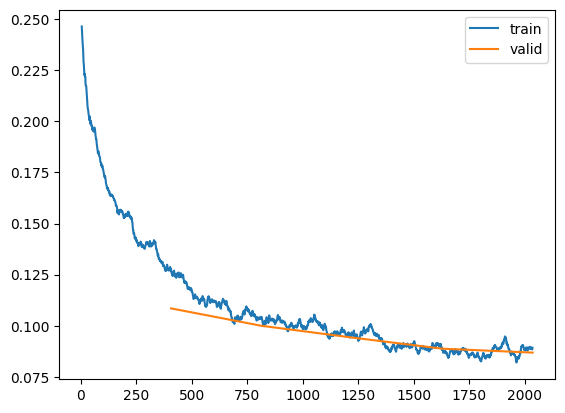

In [59]:
training_losses = learn.recorder.losses
validation_metrics = learn.recorder.metrics

learn.recorder.plot_loss()